# Bereket and William's seniment analysis neural network

website where we got the data:https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [4]:
# code to download kaggle file

# !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
# !unzip imdb-dataset-of-50k-movie-reviews.zip

# !pip install opendatasets
# import opendatasets as od

# od.download("https://www.kaggle.com/datasets/andrewmvd/steam-reviews")

!pip install -q kaggle

!kaggle datasets download -d filipkin/steam-reviews

import numpy as np
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import time
import matplotlib.pyplot as plt
import re
from google.colab import files
import glob
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [5]:
!unzip steam-reviews.zip


unzip:  cannot find or open steam-reviews.zip, steam-reviews.zip.zip or steam-reviews.zip.ZIP.


## the neural net of the hour

In [6]:
# the neural net of the hour
class reviewer(nn.Module): #this is the base model
  def __init__(self, vocab, dim):
    super().__init__()
    self.emdding = nn.Embedding(vocab, dim)
    self.lin = nn.Linear(dim, 16)
    self.lin2 = nn.Linear(16, 1)
    self.sig = nn.Sigmoid()
    self.re = nn.ReLU()
  def forward(self, x):
    embed = self.emdding(x)
    mean = torch.mean(embed, axis = 1)
    lin2 = self.lin(mean)
    relu = self.re(lin2)
    sigs = self.sig(relu)
    lin = self.lin2(sigs)
    sig = self.sig(lin)
    return sig

# class reviewer(nn.Module):
#   def __init__(self, vocab, dim):
#     super().__init__()
#     self.embedding = nn.Embedding(vocab, dim)
#     self.lin = nn.Linear(dim, 16)
#     self.lin2 = nn.Linear(16, 1)
#     self.tan = nn.Tanh()
#   def forward(self, x):
#     embed = self.embedding(x)
#     mean = torch.mean(embed, axis = 1)
#     lin = self.lin(mean)
#     tan = self.tan(lin)
#     lin2 = self.lin2(tan)
#     tanner = self.tan(lin2)
#     return tanner


## Data reading and cleaning

In [7]:
# making validation and testing data
def make_test_val(review, score, stop):
    temp_review = []
    temp_score = []
    amount = 0
    #for negative reviews
    for i in reversed(range(len(review))):
        if amount == stop//2:
            break
        if score[i] == 0.0:
            temp_review.append(review[i])
            temp_score.append(score[i])
            del score[i]
            del review[i]
            amount += 1
    #for positive reviews
    amount = 0
    for i in reversed(range(len(review))):
        if amount == stop//2:
            break
        if score[i] == 1.0:
            temp_review.append(review[i])
            temp_score.append(score[i])
            del score[i]
            del review[i]
            amount += 1

    return temp_review, temp_score, review, score

    # cleaning
def clean_data_movies(data):
    cleaned_reviews = []

    for review in data:
      soup = BeautifulSoup(review, "html.parser")
      clean_text = soup.get_text(separator="")
      clean_text=clean_text.lower()
      cleaned_reviews.append(clean_text)

    return cleaned_reviews

def clean_data_steam(data):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002700-\U000027BF"  # dingbats
    u"\U0001F900-\U0001F9FF"  # additional symbols
                        "]+", flags=re.UNICODE)

    data = emoji_pattern.sub(r'', data)

    lines = data.splitlines()
    limit = 0.6
    filtered_lines = []
    for line in lines:
        if not line.strip():
            filtered_lines.append(line)
            continue

        non_alnum_count = sum(1 for ch in line if not ch.isalnum() and not ch.isspace())
        ratio = non_alnum_count / len(line) if len(line) > 0 else 0

        # Only include lines that do not exceed the threshold
        if ratio < limit:
            filtered_lines.append(line)
    return "\n".join(filtered_lines)

In [8]:
#read in data
def make_lists():
    #review = ["a b d c a", "a b e", "e g t h", "u h o p", "a b","a b d c", "a b e", "e g t h", "u h o p", "a b","a b d c", "a b e", "e g t h", "u h o p", "a b","a b d c", "a b e", "e g t h", "u h o p", "a b","a b d c", "a b e", "e g t h", "u h o p", "a b","a b d c", "a b e", "e g t h", "u h o p", "a b"]
    #score = [1.,1.,0.,1.,0.,1.,1.,0.,1.,0.,1.,1.,0.,1.,0.,1.,1.,0.,1.,0.,1.,1.,0.,1.,0.,1.,1.,0.,1.,0.]
    review = []
    score = []
    #stop = 1000
    check = 2

    df = pd.read_csv('output.csv')

    mask = df['is_positive'].str.contains("Positive")


    df.loc[mask, 'is_positive'] = 1.0
    df.loc[~mask, 'is_positive'] = 0.0

    # Convert the entire column to numeric (floats)
    df['is_positive'] = pd.to_numeric(df['is_positive'])

    df.content = df.content.astype(str)

    review = df.content.tolist()
    score = df.is_positive.tolist()



    train_review, test_review, train_score, test_score = train_test_split(review, score, test_size=0.3)
    train_review, val_review, train_score, val_score = train_test_split(train_review, train_score, test_size=0.3)

    test_score = torch.tensor(test_score).unsqueeze(dim=-1)
    val_score = torch.tensor(val_score).unsqueeze(dim=-1)

    return train_review, train_score, test_review, test_score, val_review, val_score

## Tokenizers for train and test

In [9]:
#tokenization
def lex_order(reviews, score):
    reviews = [s.lower() for s in reviews]
    words = set()
    for i in reviews: # problem: crashed because I traid to make another list of lists of it so I can maintain the order but that was too much for memory 1/3
        i = i.lower()
        for n in i.split(): # solution found: just use the input reviews as the order and don't make a list of lists 1/7
            words.add(n)
    words = sorted(list(words))
    vocab = len(words) + 1
    hashing = {}
    order = 1
    for i in words:
        hashing[i] = order
        order += 1
    lex = []

   # make padding for training
    for review in reviews:
        lister = []
        for words in review.split():

            lister.append(hashing[words])
        lex.append(torch.tensor(lister, dtype=torch.long))
    padded = torch.nn.utils.rnn.pad_sequence(lex, batch_first=True) # crashed: used too much ram again 6.5 million reviews was far past my computers
    score = torch.tensor(score).unsqueeze(dim=-1)
    print(padded.size())
    print(score.size())
    return vocab, padded, hashing, score
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
def lex_order_new(hashing, dataset, padd_width):
    lex = []
    for review in dataset:
        lister = np.zeros((padd_width), dtype=np.int64)
        index = 0
        review = review.lower()
        for word in review.split():
            if word in hashing:
                lister[index] = hashing[word]
                index += 1
                if index == padd_width:
                    break
        lister = torch.tensor(lister, dtype=torch.long)
        lex.append(lister)

    lex = torch.nn.utils.rnn.pad_sequence(lex, batch_first=True).long()
    return lex

## graph creation for train and validation loss

In [10]:
#generate a graph
def make_Lin_graph(train_loss, val_loss):
    # Determine step based on the length of train_loss
    if len(train_loss) > 400:
        step = 50
    elif len(train_loss) < 10:
        step = 1
    else:
        step = 10

    # Create a list of indices and ensure the final index is included
    indices = list(range(0, len(train_loss), step))
    if indices[-1] != len(train_loss) - 1:
        indices.append(len(train_loss) - 1)

    # Convert indices to epoch numbers (starting at 1)
    epochs = [i + 1 for i in indices]

    plt.figure(figsize=(8, 5), dpi=100)
    # Plot the losses using the selected indices
    plt.plot(epochs, [train_loss[i] for i in indices], 'b--', label='Training Loss')
    plt.plot(epochs, [val_loss[i] for i in indices], 'r-', label='Validation Loss')

    plt.title('Training vs. Validation Loss', fontsize=16)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.show()

## test accuracy and model saving

In [11]:
# accuracy for test
def compute_accuracy(model, test_data, test_labels, epochs, batch_size):
    model.eval()
    total_correct = 0
    total_samples = 0
    device = next(model.parameters()).device  # Ensure device is defined from the model

    with torch.no_grad():
        for _ in range(epochs):
            permutation = torch.randperm(len(test_data))
            for i in range(0, len(test_data), batch_size):
                indices = permutation[i:i + batch_size]
                mini_batch = test_data[indices].to(device)
                mini_batch_labels = test_labels[indices].to(device)

                # Forward pass
                pred = model(mini_batch)
                predictions = torch.round(pred)

                # Accumulate counts
                total_correct += (predictions == mini_batch_labels).sum().item()
                total_samples += predictions.size(0)

    accuracy = (total_correct / total_samples) * 100
    print(f"accuracy = {accuracy:.2f}%")
    return accuracy


In [12]:
#saving
def saveCheckpoint(checkpoint, loops):
    counter = 1
    fileName = ""
    while glob.glob(f"model{loops}*.pth.tar"): # uses glob to use astrix to allow for overwriting files to only check for model # and not epoch -- WC
        counter+=1
    fileName = f"model{counter}_{loops}loops.pth.tar"
    torch.save(checkpoint, fileName)
    print(f"dipstick model saved as {fileName}")
    return fileName

def checkpoint(state, filename="my_checkpoint2.pth.tar"):
  print("dipstick model saved")
  torch.save(state, filename)

## training loop

In [13]:
#Training loop
# roses are red violets are blue fix this later it crashed my laptop and this thing is new
def training_loop(vocab, padding, updated_score, val_review, val_score, test_review, test_score):
    print(vocab)
    model = reviewer(vocab, 256)
    model = model.to(device)
    print('check')
    batch_size = 2000
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    loops = 500
    losses = []
    val_losses = []
    val_batch = int(batch_size * 0.8)
    for epoch in range(loops):

        randperm = torch.randperm(len(padding))
        padding, updated_score = padding[randperm].to(device), updated_score[randperm].to(device)
        model.train()
        total_loss = 0

        for i in range(0, len(padding), batch_size):

            mini_batch = padding[i:i + batch_size]
            mini_batch_labels = updated_score[i:i + batch_size]

            pred = model(mini_batch)
            loss = loss_function(pred, mini_batch_labels)

            optimizer.zero_grad()

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss / (len(padding) // batch_size))
     #validation loop time complexity be dammed

        with torch.no_grad():
            val_randomperm = torch.randperm(len(val_review))
            val_review = val_review[val_randomperm]
            val_score = val_score[val_randomperm]
            model.eval()
            val_loss = 0

            for i in range(0, len(val_review), val_batch):
                mini_batch_val = val_review[i:i +  val_batch].to(device)
                mini_batch_labels_val = val_score[i:i + val_batch].to(device)

                pred = model(mini_batch_val)
                loss_val = loss_function(pred, mini_batch_labels_val)
                val_loss += loss_val.item()
            val_losses.append(val_loss / (len(val_review) // val_batch))

            # print(f"{epoch} epochs completed")
            # print(f"{losses[-1]} current Training loss")
            # print(f"{val_losses[-1]} current validation loss")
        if epoch % 50 == 0:
          print(f"{epoch} loops have occored")
          print(f"************************************************************************************loss is:  {losses[-1]} ***")
          print(f"************************************************************************************val loss is:  {val_losses[-1]} ***")
        if epoch == loops - 1:
          print(f'{loops} completed model is done training')
          print('Graph generation has started now...')

    make_Lin_graph(losses, val_losses)
    # test dataset/accuracy

    ans = compute_accuracy(model, test_review, test_score, loops, batch_size)





     # if lowest is below 0.4 change how it works for later
    # new error: crashed bc I don't have 822 gb of ram in a laptop - found 1/7
    #solution found randomly picking 128 samples from the dataset and training on it - fixed 1/9
    #why does this work bc? I don't have 822 gb of ram and I know google won't let me use theirs
    saved_model = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    filename = saveCheckpoint(saved_model, loops)

    return model, filename, ans

# Main code

In [14]:
start_lister = time.time() # try with tanh later
review, score, test_review, test_score, val_review, val_score = make_lists()
end_lister = time.time()

In [15]:
start_lex = time.time()
vocab, padded, hashing, score = lex_order(review, score)
# print(padded)
# print(score)

with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(hashing, file)

padd_width = len(padded[0])
with open('padd_width.pkl', 'wb') as file:
    pickle.dump(padd_width, file)

test_review = lex_order_new(hashing, test_review, padd_width)# tokenize the test review

val_review = lex_order_new(hashing, val_review, padd_width)
# print(val_review)
# print(val_score)
end_lex = time.time()
print(f"takes {end_lex - start_lex} seconds to make the lex order")


torch.Size([98563, 2656])
torch.Size([98563, 1])


KeyboardInterrupt: 

In [ ]:

start_model = time.time()

my_model, filename, ans = training_loop(vocab, padded, score, val_review, val_score, test_review, test_score)
padd_width = len(padded[0])
print(f'{padd_width} is the pad width')



end_model = time.time()
total = (end_model - start_model) / 60
print(f"takes {total:.2f} minutes for training")


In [ ]:






# print("Do you want to test the data with input data or some training data?")
# answer = input()
# if answer in {"input"}:
#     testing_input(review, my_model)
print("done")
files.download(filename)

# demo functions to add later

In [ ]:
# demo functions

def testing_input(padd_width, model, hashing):

    keep_going = True
    while keep_going:
        examples = st.text_input("input: ")
        examples = lex_order_new(hashing, examples, padd_width)

        model.eval()

        if model(examples).item() <= -0.5:
            st.write("Sounds like a negative reviewer is afoot")
        elif model(examples).item() >= 0.5:
            st.write("Somebody is brimming with positivity")
        else:
            st.write("Not to hot not to cold")


        awnser = input("Do you want to try again?:  ")
        if awnser not in {"yes", "y"}:
            print("ARE YOU DOUBLE SURE YOU'RE DONE?")
            awnser = input()

            if awnser not in {"yes", "y"}:
                print("ok you are")
                keep_going = False


def checkpoint(state, filename="my_checkpoint2.pth.tar"):
    print("dipstick model saved")
    torch.save(state, filename)
# finish after model is stable-----------------------------------------------------------------------------------------------------------------------------
def testing_doc(model):
    answers = []

    with open('IMDB Dataset.csv', encoding='utf-8') as csvfile: # reading in our testing training data
        reader = csv.DictReader(csvfile)
        lister = []
        padding = []
        for row in reader:
                review = row['review']
                if row['sentiment'] == "positive":
                    answers.append(1)
                else:
                    answers.append(0)

                for word in review:
                    lister.append(word)
                padding.append(torch.tensor(lister))
                testing_tensor = torch.nn.utils.rnn.pad_sequence(padding, batch_first=True)
                model.eval()


#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


def loadCheckpoint(model, optimizer):
    while True:
        try:
            modelName = input("File name: ")
            print("Loading checkpoint...")
            checkpoint = torch.load(modelName, map_location = device, weights_only=True) # map_location is where the storage should be remapped to
            break
        except FileNotFoundError:
            print(f"{modelName} is not a valid file, please try again")

    model.load_state_dict(checkpoint['model'])
    model = model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer'])
    trainingLosses = checkpoint.get('trainingLosses', []) # saves an empty list if losses is missing
    validationLosses = checkpoint.get('validationLosses', [])
    numTrainingLoops = checkpoint.get('loops', 0)
    # print("accuracy list:", accuracyList)
    # print("losses:", losses)
    print("loaded training loops:", numTrainingLoops)
    return model, optimizer, trainingLosses, validationLosses, numTrainingLoops
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------




Model after 100 epochs
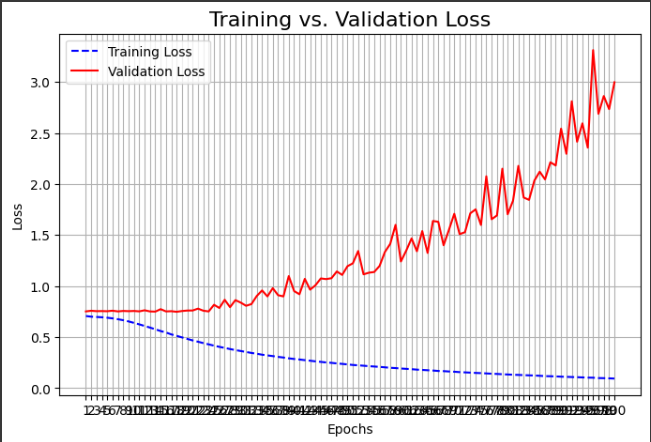

model graph after 10 loops: 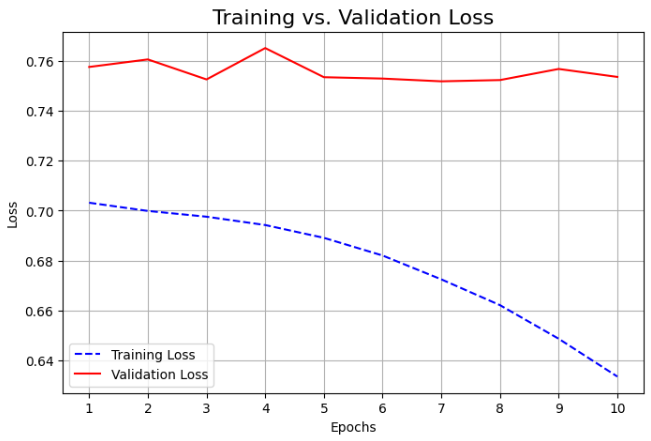

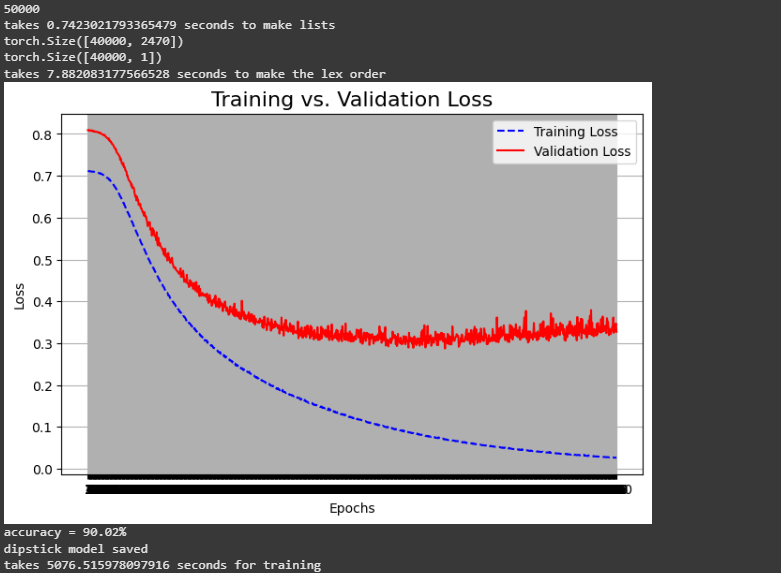

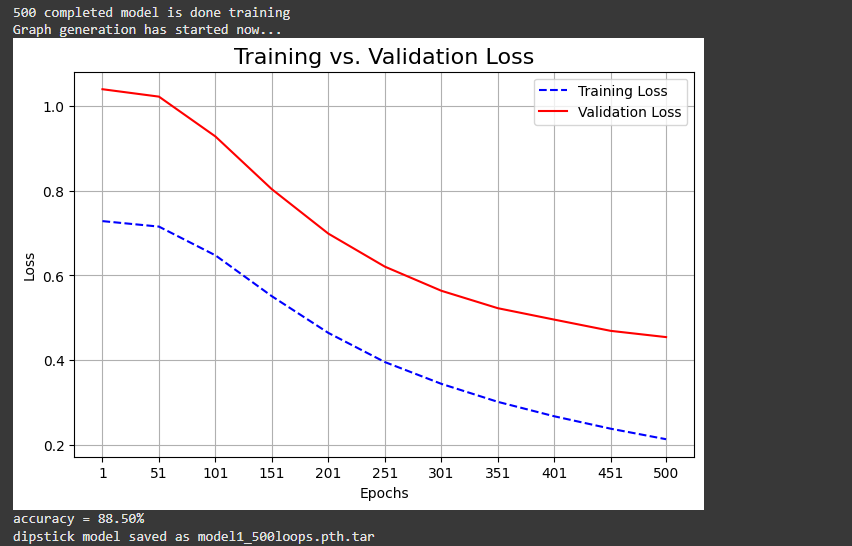

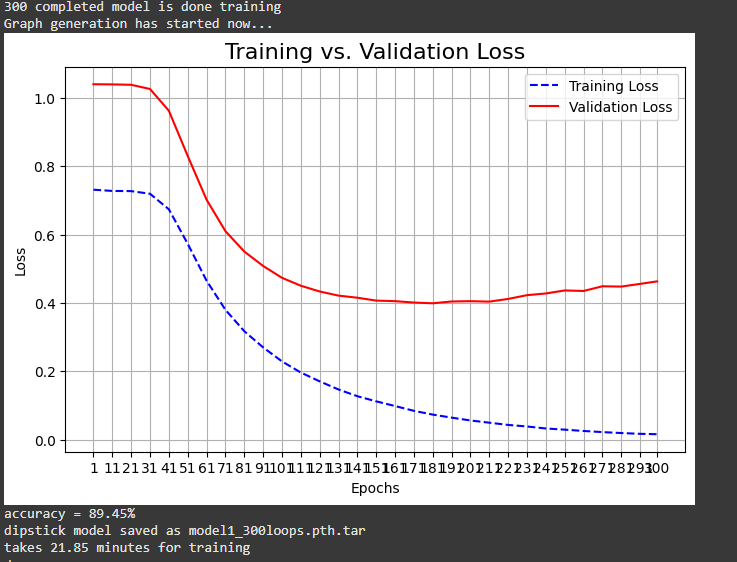

# website in python streamlit

In [ ]:
!pip install streamlit
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import io
from bs4 import BeautifulSoup
import torch
import pickle
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import numpy as np
from PIL import Image

#to run code on vs code
# open new terminal
# type python -m streamlit run chatbotweb.py
# done



# class reviewer(nn.Module):
#   def __init__(self, vocab, dim):
#     super().__init__()
#     self.embedding = nn.Embedding(vocab, dim)
#     self.lin = nn.Linear(dim, 16)
#     self.lin2 = nn.Linear(16, 1)
#     self.tan = nn.Tanh()
#   def forward(self, x):
#     embed = self.embedding(x)
#     mean = torch.mean(embed, axis = 1)
#     lin = self.lin(mean)
#     tan = self.tan(lin)
#     lin2 = self.lin2(tan)
#     tanner = self.tan(lin2)
#     return tanner
class reviewer(nn.Module): #this is the base model
  def __init__(self, vocab, dim):
    super().__init__()
    self.emdding = nn.Embedding(vocab, dim)
    self.lin = nn.Linear(dim, 16)
    self.lin2 = nn.Linear(16, 1)
    self.sig = nn.Sigmoid()
    self.re = nn.ReLU()
  def forward(self, x):
    embed = self.emdding(x)
    mean = torch.mean(embed, axis = 1)
    lin2 = self.lin(mean)
    relu = self.re(lin2)
    sigs = self.sig(relu)
    lin = self.lin2(sigs)
    sig = self.sig(lin)
    return sig


vocab = 367809

my_model = reviewer(vocab, 256)


checkpoint = torch.load('model1_200loops.pth.tar', map_location=torch.device('cpu'))


my_model.load_state_dict(checkpoint['state_dict'])


with open('tokenizer (1).pkl', 'rb') as file:
   tokenizer = pickle.load(file)


buffer = io.StringIO()

df = pd.read_csv('IMDB Dataset.csv')

mask = df['sentiment'].str.contains("positive")


df.loc[mask, 'sentiment'] = 1.0
df.loc[~mask, 'sentiment'] = 0.0

def clean_data_movies(data):
    cleaned_reviews = []

    for review in data:
      soup = BeautifulSoup(review, "html.parser")
      clean_text = soup.get_text(separator="")
      clean_text=clean_text.lower()
      cleaned_reviews.append(clean_text)

    return cleaned_reviews

def lex_order_new(hashing, dataset, padd_width):
    lex = []

    lister = np.zeros((padd_width), dtype=np.int64)
    index = 0
    review = dataset.lower()
    for word in review.split():
        if word in hashing:
            lister[index] = hashing[word]
            index += 1
            if index == padd_width:
                break
    lister = torch.tensor(lister, dtype=torch.long)
    lex.append(lister)

    lex = torch.nn.utils.rnn.pad_sequence(lex, batch_first=True).long()
    return lex



def testing_input(padd_width, model, hashing):
    # Get user input via a text box
    user_text = st.text_input("Enter your review:")

    # When the button is clicked, process the input
    if st.button("Analyze"):
        # Check if the input is empty
        if not user_text:
            st.write("Please try again. Empty input is not valid.")
        else:
            # Preprocess the input as needed
            examples = lex_order_new(hashing, user_text, padd_width)

            model.eval()
            prediction = model(examples).item()

            # Display the result based on the prediction value
            if prediction < 0.5:
                st.write("Sounds like a negative reviewer is afoot")
            else:
                st.write("Somebody is brimming with positivity")




def make_lists():
    #review = ["a b d c a", "a b e", "e g t h", "u h o p", "a b","a b d c", "a b e", "e g t h", "u h o p", "a b","a b d c", "a b e", "e g t h", "u h o p", "a b","a b d c", "a b e", "e g t h", "u h o p", "a b","a b d c", "a b e", "e g t h", "u h o p", "a b","a b d c", "a b e", "e g t h", "u h o p", "a b"]
    #score = [1.,1.,0.,1.,0.,1.,1.,0.,1.,0.,1.,1.,0.,1.,0.,1.,1.,0.,1.,0.,1.,1.,0.,1.,0.,1.,1.,0.,1.,0.]
    review = []
    score = []
    #stop = 1000
    check = 2

    df = pd.read_csv('IMDB Dataset.csv')

    mask = df['sentiment'].str.contains("positive")


    df.loc[mask, 'sentiment'] = 1.0
    df.loc[~mask, 'sentiment'] = 0

    # Convert the entire column to numeric (floats)
    df['sentiment'] = pd.to_numeric(df['sentiment'])

    review = df.review.tolist()
    score = df.sentiment.tolist()



    review = clean_data_movies(review)
    return review, df


reviews, df = make_lists()

my_series = pd.Series(reviews, name='reviews')
df['review'] = my_series

df['sentiment'].info(buf=buffer)
info_str = buffer.getvalue()
st.title('Data used')
st.write("In this model we used publicly available reviews from IMDB.")
st.write("Using a multitude of Python libraries to parse through, clean, and verify the data for training, such as pandas and beautiful soup.")
st.write('Below is the data representing the user sentiment after cleaning.')




st.write('An sample of the reviews and scores after cleaning.')

st.write(df.head(20))
st.text(info_str)

st.title('Training')
st.write('Training improvements: Below is the model from before countless hours of efficiency improvements were made.')
img = Image.open("1000loops.JPG")
st.image(img, caption="Before improvements")
img2 = Image.open('200loop.JPG')
st.image(img2, caption='After')
st.write('The graphs shown above are from the beginning, and after optimization, the model went from taking approximately an hour to a mere 15 minutes to train.')
st.title("Interactive sentiment analysis") # put something on the screen

st.write('The fully trained model in the back end is ready to read, analyze, and predict based on your input.')
testing_input(padd_width=2450, hashing=tokenizer, model=my_model)

